In [1]:
import sys
sys.path.append('/home/xavier/Documents/dcml/python_scripts')

from metric import get_distance
from data_types import ChordType, PitchType
from utils import get_chord_pitches
from constants import TRIAD_REDUCTION
from progression import get_progression, plot_comparison
from fractions import Fraction


import numpy as np
import networkx as nx
import pandas as pd

In [2]:
def compare_notes(
    note1: int,
    note2: int
) -> (int, int):
    """
    Find the smallest interval between tow given midi notes by shifting them by 
    one or more octaves and return the shifted notes. --> rename : get normalized note, min(abs%12, abs%12-12)

    Parameters
    ----------
    note1 : int
        Midi number of the first note.
    note2 : int
        Midi number of the second note

    Returns
    -------
    (int, int)
        Midi numbers of the two shiftd notes.

    """
    if note1 - note2 < 0 :
        while np.abs(note1 - note2 + 12) <= np.abs(note1 - note2):
            note1 += 12
            
    else :
        while np.abs(note1 - note2 - 12) <= np.abs(note1 - note2):
            note2 += 12
    
    return note1, note2

In [3]:
def get_smallest_interval(
    note1: int,
    note2: int
) -> int:
    """
    Find the smallest interval between tow given midi notes by shifting them by 
    one or more octaves and return the shifted notes. --> rename : get normalized note, min(abs%12, abs%12-12)

    Parameters
    ----------
    note1 : int
        Midi number of the first note.
    note2 : int
        Midi number of the second note

    Returns
    -------
    (int, int)
        Midi numbers of the two shiftd notes.

    """
    
    diff = np.abs(note1-note2)%12
    
    return min(diff, 12-diff)

In [4]:
get_smallest_interval(3, 11)

4

In [5]:
def find_high_notes_min_steps(
    notes1:int,
    notes2:int
):
    # Matrix that keep the number of semi-tones between each pair of pitches between 
	# the two chords.
    similarities = np.ndarray((len(notes1), len(notes2)))
    
    # Graph for the matching
    G = nx.Graph()

    for idx1, note1 in enumerate(notes1):
        for idx2, note2 in enumerate(notes2):
				
            similarity = 6 - get_smallest_interval(note1,note2)  # 6 being the maximum number 
                                                                     # semi-tones between two pitches
                                                                     # convertion of a distance to similarity
													 
            similarities[idx1,idx2] = similarity 
				      
			# the second node is define by the length of the first chord plus 
			# the index of the corresponding pitch within the second chord 
            G.add_weighted_edges_from([(idx1,idx2+len(notes1), similarity)])
            
    matching = nx.max_weight_matching(G, maxcardinality=True)
    matching = [(pair[0], pair[1]-len(notes1)) for pair in matching]
	# Total distance							          
    total_steps = 0
    for pair in matching:
			
		# We substract the length of the first chord to the second node of the
		# matching to the index of the corresponding pitch within the second chord
        total_steps+=6-similarities[pair[0], pair[1]]
            
    return total_steps, matching

In [598]:
root1=0
root2=0
chord_type1=ChordType.MAJOR
chord_type2=ChordType.DIMINISHED
inversion1=0
inversion2=2

bass_weight=3
duplicate_bass=True
pitch_type = PitchType.MIDI

In [599]:
voice_leading_distance(root1=root1,
                      root2=root2,
                      chord_type1=chord_type1,
                      chord_type2=chord_type2,
                      inversion1=inversion1,
                      inversion2=inversion2,
                      duplicate_bass=duplicate_bass,
                      bass_weight=bass_weight)

20.0

In [586]:
notes1 = pd.Series(get_chord_pitches(root = root1,
                                     chord_type = chord_type1,
                                     pitch_type = pitch_type,
                                         inversion = inversion1))
notes1

0    0
1    4
2    7
dtype: int64

In [587]:
notes2 = pd.Series(get_chord_pitches(root = root2,
                                         chord_type = chord_type2,
                                     pitch_type = pitch_type,
                                         inversion = inversion2))
notes2

0   -6
1    0
2    3
dtype: int64

In [588]:
total_steps=0
similarities = np.ndarray((len(notes1), len(notes2)))
    
bass_steps = get_smallest_interval(notes1[0],notes2[0])
    
G = nx.Graph()

if duplicate_bass :
    for idx1, note1 in notes1.items():
        for idx2, note2 in notes2.items():
	        
            similarity = 6 - get_smallest_interval(note1,note2)
            similarities[idx1,idx2] = similarity
            print(idx1,idx2, 6-similarity)
	    
            G.add_weighted_edges_from([(idx1,idx2+len(notes1), similarity)])
    
else :
    for idx1, note1 in notes1[1:].items():
        for idx2, note2 in notes2[1:].items():
	        
            similarity = 6 - get_smallest_interval(note1,note2)
            similarities[idx1,idx2] = similarity
            print(idx1,idx2, 6-similarity)
	    
            G.add_weighted_edges_from([(idx1,idx2+len(notes1), similarity)])
            
matching = nx.max_weight_matching(G, maxcardinality=True)
	
for pair in matching:
    if pair != (0, len(notes1)):
            total_steps+=6-similarities[pair[0], pair[1]-len(notes1)]
similarities[0,0] = bass_steps
total_steps += bass_weight*bass_steps
total_steps

0 0 6
0 1 0
0 2 3
1 0 2
1 1 4
1 2 1
2 0 1
2 1 5
2 2 4


20.0

In [589]:
bass_steps

6

In [590]:
matching

{(0, 4), (1, 5), (2, 3)}

In [591]:
matching = [(pair[0], pair[1]-len(notes1)) for pair in matching]
matching

[(2, 0), (0, 1), (1, 2)]

In [592]:
if duplicate_bass :
    dist, matching = find_high_notes_min_steps(notes1, notes2)
    dist += (bass_weight-1)*get_smallest_interval(notes1[0],notes2[0])

else :
    dist, matching = find_high_notes_min_steps(notes1[1:], notes2[1:])
    matching=[(0,0)]+[(pair[0]+1, pair[1]+1) for pair in matching]
    dist += bass_weight*get_smallest_interval(notes1[0],notes2[0])


matching

[(2, 0), (0, 1), (1, 2)]

In [593]:
dist

14.0

In [594]:
if len(notes1)!=len(notes2):
    if len(notes1)>len(notes2):
        big_chord = notes1.copy()
        bc_idx = 0
        short_chord = notes2.copy()
    elif len(notes1)<len(notes2):
        big_chord = notes2.copy()
        bc_idx = 1
        short_chord = notes1.copy()
            
    for pair in matching:
        idx = pair[bc_idx]
        big_chord.drop(idx, inplace=True)
            
big_chord

Series([], dtype: int64)

In [595]:
for note_b in big_chord:
    dist += min([get_smallest_interval(note_b,note_s) for note_s in short_chord])
dist

14.0

In [491]:
if len(notes1)!=len(notes2):
  
    while (len(big_chord)!=0):
        G = nx.Graph()
        for idx_b, note_b in big_chord.items():
            for idx_s, note_s in short_chord.items():
                
                note_b, note_s = compare_notes(note_b, note_s)
                similarity = 6-np.abs(note_b-note_s)
                if bc_idx :
                    similarities[idx_s,idx_b] = similarity
                    G.add_weighted_edges_from([(idx_b,idx_s+len(notes2),
                                                    similarity)])
                else :
                    similarities[idx_b,idx_s] = similarity
                    G.add_weighted_edges_from([(idx_b,idx_s+len(notes1),
                                                    similarity)])        
                
        matching = nx.max_weight_matching(G)
        for pair in matching:
            big_chord.drop(pair[0], inplace=True)
            if bc_idx :
                total_steps+=6-similarities[pair[1]-len(notes2), pair[0]]
            else :
                total_steps+=6-similarities[pair[0], pair[1]-len(notes1)]

In [492]:
matching

{(0, 4)}

In [493]:
matching = [(pair[0], pair[1]-len(short_chord)) for pair in matching]
matching

[(0, 1)]

In [494]:
total_steps

5.0

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast


from fractions import Fraction

from metric import get_distance
from data_types import ChordType

PITCH_TO_STRING = {0:'C',1:'Db',2:'D',3:'Eb',4:'E',5:'F',
                   6:'Gb',7:'G',8:'Ab',9:'A',10:'Bb',11:'B'}

def overlap(
    i1:float,
    i2:float
) -> bool:
	"""
	Retrun if the two intervals overlap

	Parameters
	----------
	i1 : float
		first interval : array of two elements.
	i2 : float
		second interval : array of two elements.

	Returns
	-------
	bool
		True if the two intervals overlap.

	"""
	if i1[1]>i2[0] and i1[1]<=i2[1]:
		return True
	if i2[1]>i1[0] and i2[1]<=i1[1]:
		return True
	return False


def duration_overlap(
    i1:float,
    i2:float
) -> float:
	"""
	Return the duration of the common section of the two intervals.

	Parameters
	----------
	i1 : float
		first interval : array of two elements.
	i2 : float
		second interval : array of two elements.

	Returns
	-------
	float
		duration of the common section of the two intervals.

	"""
	if i1[1]>i2[0] and i1[1]<=i2[1]:
		if i1[0]<i2[0]:
			return i1[1]-i2[0]
		else :
			return i1[1]-i1[0]
	if i2[1]>i1[0] and i2[1]<=i1[1]:
		if i2[0]<i1[0]:
			return i2[1]-i1[0]
		else :
			return i2[1]-i2[0]
	return 0

In [3]:
nb = 1
nb = str(nb) 
nb = nb if len(nb)>1 else '0'+ nb 
fh_path =  '../Data/Beethoven_sonata_fh/' + nb + '-1.csv'
dcml_path =  '../Data/Beethoven_sonata_dcml/' + nb + '-1.csv'

PITCH_TO_STRING = {0:'C',1:'Db',2:'D',3:'Eb',4:'E',5:'F',
                   6:'Gb',7:'G',8:'Ab',9:'A',10:'Bb',11:'B'}

fh_df = pd.read_csv(fh_path, converters={'duration': Fraction})
fh_df['chord_type'] = fh_df['chord_type'].apply(lambda r : ChordType[r.split(".")[1]])
fh_df['full_chord'] = fh_df.apply(lambda r : PITCH_TO_STRING[r.chord_root_midi] + '_' + str(r.chord_type).split(".")[1]+"_inv"+str(r.chord_inversion), axis=1)    

features = ['interval', 'matched_idx', 'matched_duration', 'chords_sps_dist', 'chords_vl_dist', 'chords_tbt_dist']
for feature in features :
    fh_df[feature] = fh_df[feature].apply(lambda r : ast.literal_eval(r))
    
dcml_df = pd.read_csv(dcml_path, converters={'duration': Fraction})
dcml_df['chord_type'] = dcml_df['chord_type'].apply(lambda r : ChordType[r.split(".")[1]])
dcml_df['full_chord'] = dcml_df.apply(lambda r : PITCH_TO_STRING[r.chord_root_midi] + '_' + str(r.chord_type).split(".")[1]+"_inv"+str(r.chord_inversion), axis=1)    
dcml_df['interval'] = dcml_df['interval'].apply(lambda r : ast.literal_eval(r))

In [15]:
df1 = pd.read_csv("../Data/Beethoven-labels/dcml-03-1.tsv", sep='\t')
df1['chord_type'] = df1['chord_type'].apply(lambda r : ChordType[r.split(".")[1]])

df2 = pd.read_csv("../Data/Beethoven-labels/fh-03-1.tsv", sep='\t')
df2['chord_type'] = df2['chord_type'].apply(lambda r : ChordType[r.split(".")[1]])

In [16]:
def test_columns(df:pd.DataFrame):
    columns_df=df.columns
    if 'chord_root_midi' not in columns_df:
        raise KeyError("'chord_root_midi' must be a column of the data frame.")

    if 'chord_type' not in columns_df:
        raise KeyError("'chord_type' must be a column of the data frame.")


    if 'chord_inversion' not in columns_df:
        raise KeyError("'chord_inversion' must be a column of the data frame.")

    if 'duration' not in columns_df:
        raise KeyError("'duration' must be a column of the data frame.")
        
    df1['duration'] = df1['duration'].apply(lambda r : Fraction(r))
    df2['duration'] = df2['duration'].apply(lambda r : Fraction(r))

In [17]:
test_columns(df1)
test_columns(df2)

df1_full_chord = df1.apply(lambda r : PITCH_TO_STRING[r.chord_root_midi] + '_' + str(r.chord_type).split(".")[1]+"_inv"+str(r.chord_inversion), axis=1)
df2_full_chord = df2.apply(lambda r : PITCH_TO_STRING[r.chord_root_midi] + '_' + str(r.chord_type).split(".")[1]+"_inv"+str(r.chord_inversion), axis=1)

time_df1 = df1.duration.cumsum().astype(float, copy=False)
df1_interval = [[i, f] for i, f in zip([0]+list(time_df1[:-1]), time_df1)]

time_df2 = df2.duration.cumsum().astype(float, copy=False)
df2_interval = [[i, f] for i, f in zip([0]+list(time_df2[:-1]), time_df2)]


sps = []
vl  = []
tbt = []
binary = []
	
time = []
	
chords_df2 = []
chords_df1 = []

idx_df1 = 0
for idx_df2, rdf2 in df2.iterrows():
	matched_idx = []
	matched_duration = []
	chords_sps_dist = []
	chords_vl_dist = []
	chords_tbt_dist = []
        
	if (idx_df1 > 0 and overlap(df1_interval[idx_df1-1], df2_interval[idx_df2])):
            
		matched_idx.append(idx_df1-1)
            
		matched_duration.append(duration_overlap(df1_interval[idx_df1-1], df2_interval[idx_df2]))
            
		chords_sps_dist.append(get_distance(distance = 'SPS',
                                               root1=df1.chord_root_midi[idx_df1-1],
                                               root2=rdf2.chord_root_midi,
                                               chord_type1=df1.chord_type[idx_df1-1],
                                               chord_type2=rdf2.chord_type,
                                               inversion1=df1.chord_inversion[idx_df1-1],
                                               inversion2=rdf2.chord_inversion))

		chords_vl_dist.append(get_distance(distance = 'voice leading',
                                               root1=df1.chord_root_midi[idx_df1-1],
                                               root2=rdf2.chord_root_midi,
                                               chord_type1=df1.chord_type[idx_df1-1],
                                               chord_type2=rdf2.chord_type,
                                               inversion1=df1.chord_inversion[idx_df1-1],
                                               inversion2=rdf2.chord_inversion,
                                               bass_weight = 3))

		chords_tbt_dist.append(get_distance(distance = 'tone by tone',
                                               root1=df1.chord_root_midi[idx_df1-1],
                                               root2=rdf2.chord_root_midi,
                                               chord_type1=df1.chord_type[idx_df1-1],
                                               chord_type2=rdf2.chord_type,
                                               inversion1=df1.chord_inversion[idx_df1-1],
                                               inversion2=rdf2.chord_inversion,
                                               bass_weight = 3,
                                               root_weight = 3))

	while(idx_df1 < len(df1) and overlap(df1_interval[idx_df1], df2_interval[idx_df2])):
            
		matched_idx.append(idx_df1)
            
		matched_duration.append(duration_overlap(df1_interval[idx_df1], df2_interval[idx_df2]))
            
		chords_sps_dist.append(get_distance(distance = 'SPS',
                                               root1=df1.chord_root_midi[idx_df1],
                                               root2=rdf2.chord_root_midi,
                                               chord_type1=df1.chord_type[idx_df1],
                                               chord_type2=rdf2.chord_type,
                                               inversion1=df1.chord_inversion[idx_df1],
                                               inversion2=rdf2.chord_inversion))

		chords_vl_dist.append(get_distance(distance = 'voice leading',
                                               root1=df1.chord_root_midi[idx_df1],
                                               root2=rdf2.chord_root_midi,
                                               chord_type1=df1.chord_type[idx_df1],
                                               chord_type2=rdf2.chord_type,
                                               inversion1=df1.chord_inversion[idx_df1],
                                               inversion2=rdf2.chord_inversion,
                                               bass_weight = 3))

		chords_tbt_dist.append(get_distance(distance = 'tone by tone',
                                               root1=df1.chord_root_midi[idx_df1],
                                               root2=rdf2.chord_root_midi,
                                               chord_type1=df1.chord_type[idx_df1],
                                               chord_type2=rdf2.chord_type,
                                               inversion1=df1.chord_inversion[idx_df1],
                                               inversion2=rdf2.chord_inversion,
                                               bass_weight = 3,
                                               root_weight = 3))

		idx_df1 += 1
		
	dist_bin = [0 if tbt == 0 else 1 for tbt in chords_tbt_dist]
	    
	sps+=chords_sps_dist
	vl +=chords_vl_dist
	tbt+=chords_tbt_dist
	binary+=dist_bin
	    
	if len(matched_idx)>0:
	        
		time.append(df2_interval[idx_df2][0])
		if len(matched_idx)>1:
			for duration in matched_duration:
				time.append(df2_interval[idx_df2][0]+duration)
			del time[-1]
	        
		chords_df2 += [df2_full_chord[idx_df2]]*len(matched_idx)
		chords_df1 += [df1_full_chord[idx_df1] for idx_df1 in matched_idx]
            
progression = pd.DataFrame({'time':time,
	                            'annotation1_chord':chords_df1,
	                            'annotation2_chord':chords_df2,
	                            'sps':sps,
	                            'vl':vl,
	                            'tbt':tbt,
	                            'binary':binary})


In [18]:
progression

,time,annotation1_chord,annotation2_chord,sps,vl,tbt,binary
0,0.0000,C_MAJOR_inv0,C_MAJOR_inv0,0.000000,0.0,0.000,0
1,0.5000,C_MAJOR_inv0,C_MAJOR_inv0,0.000000,0.0,0.000,0
2,0.5625,C_MAJOR_inv0,C_MAJOR_inv0,0.000000,0.0,0.000,0
3,0.6250,C_MAJOR_inv0,C_MAJOR_inv0,0.000000,0.0,0.000,0
4,0.6875,C_MAJOR_inv0,C_MAJOR_inv0,0.000000,0.0,0.000,0
...,...,...,...,...,...,...,...
2392,255.0000,C_MAJOR_inv0,D_MINOR_inv1,0.813390,20.0,1.000,1
2393,255.2500,C_MAJOR_inv0,D_MINOR_inv1,0.813390,20.0,1.000,1
2394,255.5000,G_MAJ_MIN7_inv0,D_MINOR_inv1,0.415949,10.0,0.750,1
2395,256.0000,C_MAJOR_inv0,G_MAJ_MIN7_inv0,0.704164,19.0,0.875,1


In [38]:

def plot_comparison(
    progression:pd.DataFrame,
    rge:float=None,
    verbose:bool=False,
	title:str=None
	): 
	"""
	Plot the progression of 2 annotaions

	Parameters
	----------
	progression : pd.DataFrame
		pd.DataFrame containg progressino the two annotaion and their distance for
		each chord.
	rge : float, optional
		the range in terms of whole note of the progression : a 2-element array. 
		The default is None.
	verbose : bool, optional
		if True the name of each chord of the two annotation will be marked under 
		the dot of the event. The default is False.
	title : str, optional
		Title of the plot. The default is None.

	Returns
	-------
	None.

	"""
	if rge==None:
		 rge=[progression.time[0],progression.time.iloc[-1]]

	fig, axs = plt.subplots(2,1,figsize=(22,10), sharex=True)

	sns.scatterplot(data=progression.query('time>=@rge[0] and time<@rge[1]'), x='time', y='sps',ax=axs[0], label='SPS')
	sns.scatterplot(data=progression.query('time>=@rge[0] and time<@rge[1]'), x='time', y='tbt',ax=axs[0], label='tone by tone')
	axs[0].grid()
	axs[0].set(xlabel='time', ylabel='distance to matched chord')

	sns.scatterplot(data=progression.query('time>=@rge[0] and time<@rge[1]'), x='time', y='vl',ax=axs[1], label='voice leading')
	axs[1].grid()
	axs[1].set(xlabel='time', ylabel='distance to matched chord')

	if verbose:
        
		limit1=progression.query('time>=@rge[0] and time<@rge[1]').index[0]
		limit2=progression.query('time>=@rge[0] and time<@rge[1]').index[-1]
        
		plt.text(progression.iloc[limit1].time, progression.iloc[limit1].vl-0.5, progression.iloc[limit1].fh_chord, horizontalalignment='center', verticalalignment='top', size='small', fontstretch ='normal', color='maroon')
		for line in range(limit1+1,limit2):
			 if progression.fh_chord[line] != progression.fh_chord[line-1]:
				 plt.text(progression.time[line], progression.vl[line]-0.5, progression.fh_chord[line], horizontalalignment='center', verticalalignment='top', size='small', fontstretch ='normal', color='maroon')

		plt.text(progression.iloc[limit1].time, progression.iloc[limit1].vl+0.5, progression.iloc[limit1].dcml_chord, horizontalalignment='center', verticalalignment='bottom', size='small', fontstretch ='normal')
		for line in range(limit1+1,limit2):
			if progression.dcml_chord[line] != progression.dcml_chord[line-1]:
				plt.text(progression.time[line], progression.vl[line]+0.5, progression.dcml_chord[line], horizontalalignment='center', verticalalignment='bottom', size='small', fontstretch ='normal')


	if not title==None:
		fig.suptitle(title);
    
    
	fig.tight_layout()


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 64)

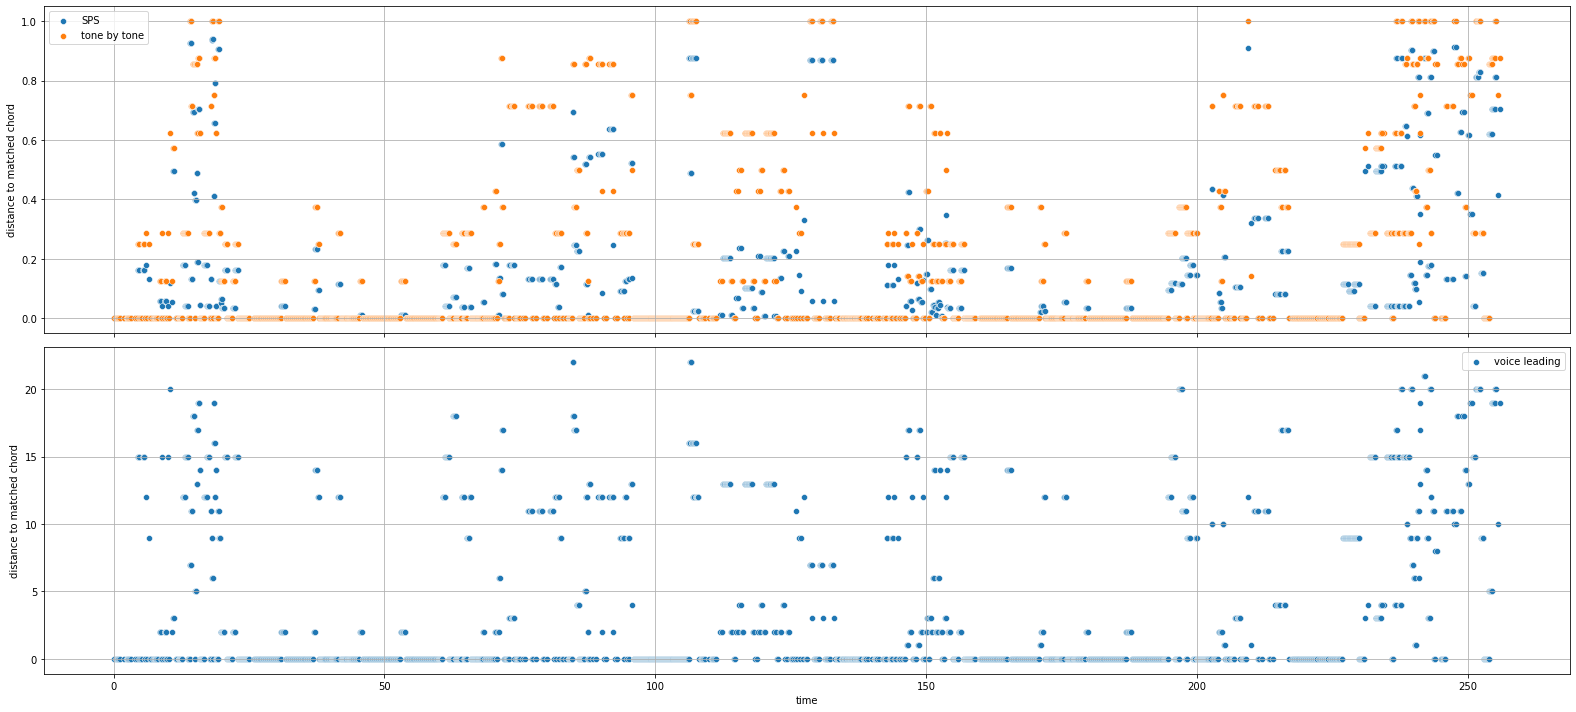

In [34]:
plot_comparison(progression)

In [21]:
df2

,chord_root_tpc,chord_root_midi,chord_type,chord_inversion,key_tonic_tpc,key_tonic_midi,key_mode,duration
0,0,0,ChordType.MAJOR,0,0,0,KeyMode.MAJOR,1/2
1,0,0,ChordType.MAJOR,0,0,0,KeyMode.MAJOR,1/16
2,0,0,ChordType.MAJOR,0,0,0,KeyMode.MAJOR,1/16
3,0,0,ChordType.MAJOR,0,0,0,KeyMode.MAJOR,1/16
4,0,0,ChordType.MAJOR,0,0,0,KeyMode.MAJOR,1/16
...,...,...,...,...,...,...,...,...
2410,1,7,ChordType.MAJ_MIN7,0,0,0,KeyMode.MAJOR,1/16
2411,1,7,ChordType.MAJ_MIN7,0,0,0,KeyMode.MAJOR,1/16
2412,0,0,ChordType.MAJOR,0,0,0,KeyMode.MAJOR,1/2
2413,1,7,ChordType.MAJ_MIN7,0,0,0,KeyMode.MAJOR,1/2
